# Data load

(60000, 784)
(60000,)
(10000, 784)
(10000,)


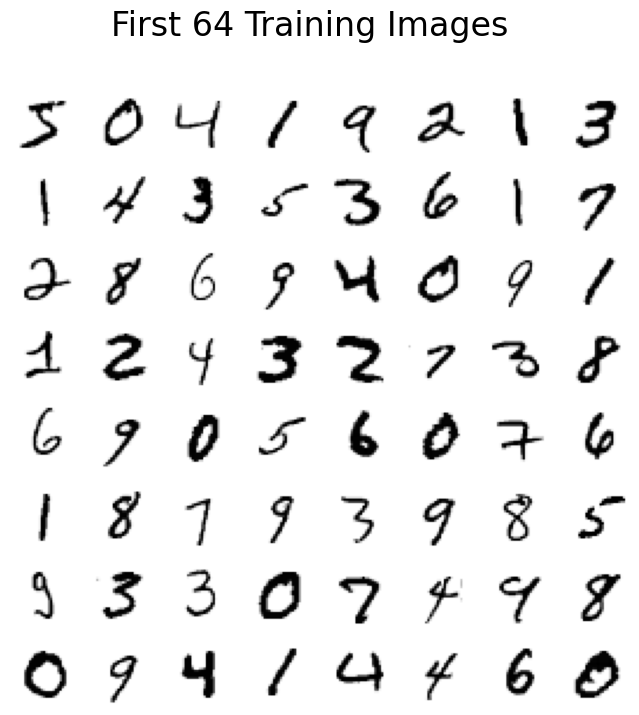

In [12]:
import numpy as np
import struct
import matplotlib.pyplot as plt

# Load training images
with open('data/train-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.uint8)
    Xtraindata = data.reshape((size, nrows * ncols))

# Load training labels
with open('data/train-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    ytrainlabels = np.fromfile(f, dtype=np.uint8)

# Load test images
with open('data/t10k-images.idx3-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.uint8)
    Xtestdata = data.reshape((size, nrows * ncols))

# Load test labels
with open('data/t10k-labels.idx1-ubyte','rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    ytestlabels = np.fromfile(f, dtype=np.uint8)

# Print new shapes
print(Xtraindata.shape)
print(ytrainlabels.shape)
print(Xtestdata.shape)
print(ytestlabels.shape)

# Function to plot images
def plot_digits(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
        for j in range(N):
            ax[i, j].imshow(XX[(N) * i + j].reshape((28, 28)), cmap="Greys")  # Now index properly
            ax[i, j].axis("off")
    fig.suptitle(title, fontsize=24)

# Plot first 64 images
plot_digits(Xtraindata, 8, "First 64 Training Images")

# Part 1

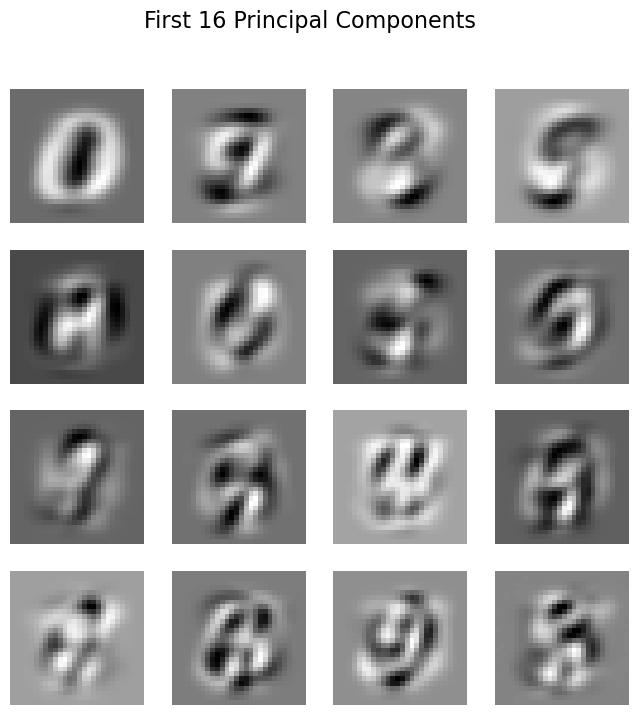

In [14]:
import numpy as np
import struct
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Apply PCA
pca = PCA(n_components=16)
X_pca = pca.fit_transform(Xtraindata)

# Retrieve the first 16 principal components
pca_modes = pca.components_.reshape(16, 28, 28)

# Plot the first 16 PC modes as 28x28 images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca_modes[i], cmap="gray")
    ax.axis("off")
plt.suptitle("First 16 Principal Components", fontsize=16)
plt.show()

# Part 2

Number of principal components needed to retain 85% variance: 59


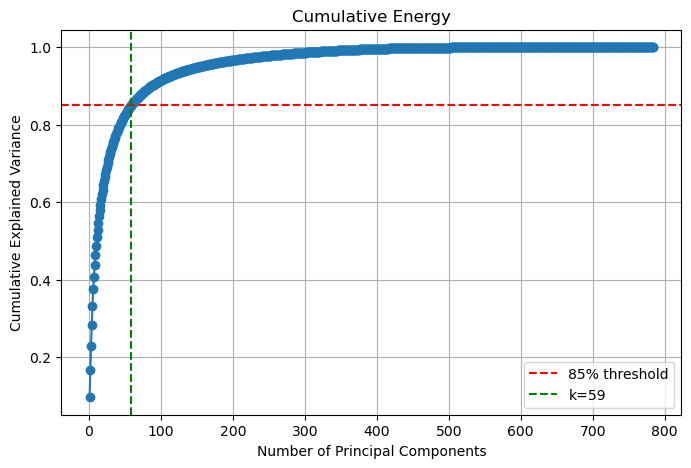

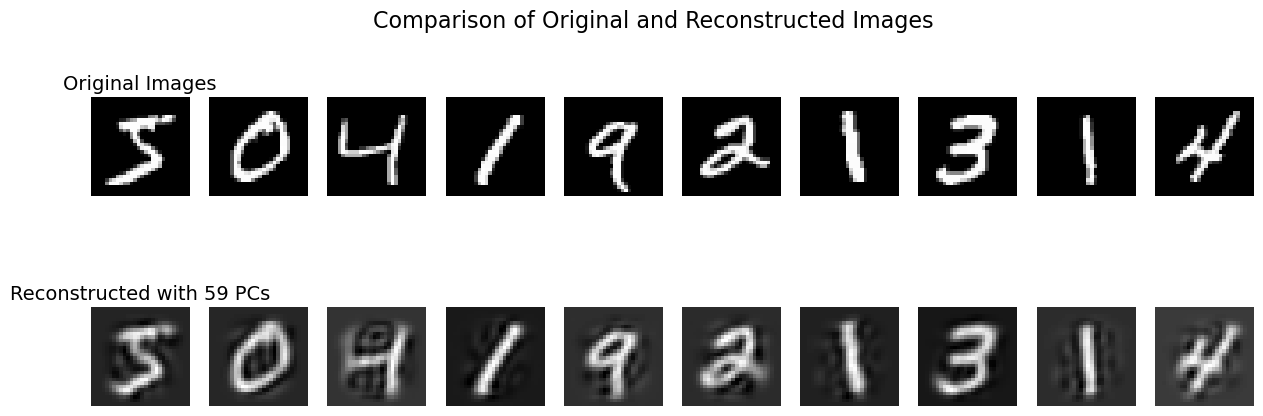

In [16]:
# Compute the explained variance ratio
pca_full = PCA(n_components=min(Xtraindata.shape))  # Use max possible components
pca_full.fit(Xtraindata)
explained_variance_ratio = np.cumsum(pca_full.explained_variance_ratio_)

# Determine the number of components needed to retain 85% of the variance
k = np.argmax(explained_variance_ratio >= 0.85) + 1
print(f"Number of principal components needed to retain 85% variance: {k}")

# Plot cumulative energy of singular values
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.axhline(y=0.85, color='r', linestyle='--', label="85% threshold")
plt.axvline(x=k, color='g', linestyle='--', label=f"k={k}")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Energy")
plt.legend()
plt.grid()
plt.show()

# Reconstruct images using the first k principal components
pca_k = PCA(n_components=k)
X_train_reduced = pca_k.fit_transform(Xtraindata)  # Now correctly in (60000, k)
X_train_reconstructed = pca_k.inverse_transform(X_train_reduced)  # Back to (60000, 784)

# Visualize original vs reconstructed images
num_images = 10  # Number of images to visualize
fig, axes = plt.subplots(2, num_images, figsize=(15, 5))

for i in range(num_images):
    # Original image
    axes[0, i].imshow(Xtraindata[i].reshape(28, 28), cmap="gray")
    axes[0, i].axis("off")

    # Reconstructed image
    axes[1, i].imshow(X_train_reconstructed[i].reshape(28, 28), cmap="gray")
    axes[1, i].axis("off")

axes[0, 0].set_title("Original Images", fontsize=14)
axes[1, 0].set_title(f"Reconstructed with {k} PCs", fontsize=14)
plt.suptitle("Comparison of Original and Reconstructed Images", fontsize=16)
plt.show()


# Part 3

In [18]:
def select_digit_subset(Xtraindata, ytrainlabels, Xtestdata, ytestlabels, selected_digits):
    # Select indices for training set
    train_indices = np.isin(ytrainlabels, selected_digits)
    X_subtrain = Xtraindata[train_indices, :]
    y_subtrain = ytrainlabels[train_indices]

    # Select indices for test set
    test_indices = np.isin(ytestlabels, selected_digits)
    X_subtest = Xtestdata[test_indices, :]
    y_subtest = ytestlabels[test_indices]

    return X_subtrain, y_subtrain, X_subtest, y_subtest

# Example usage:
selected_digits = [1, 8]
X_subtrain, y_subtrain, X_subtest, y_subtest = select_digit_subset(Xtraindata, ytrainlabels, Xtestdata, ytestlabels, selected_digits)

# Print shapes to verify
print(f"X_subtrain shape: {X_subtrain.shape}, y_subtrain shape: {y_subtrain.shape}")
print(f"X_subtest shape: {X_subtest.shape}, y_subtest shape: {y_subtest.shape}")

X_subtrain shape: (12593, 784), y_subtrain shape: (12593,)
X_subtest shape: (2109, 784), y_subtest shape: (2109,)


# Part 4

Classification for digits 1 and 8:
Best cross-validation accuracy: 0.9643
Test accuracy: 0.9801


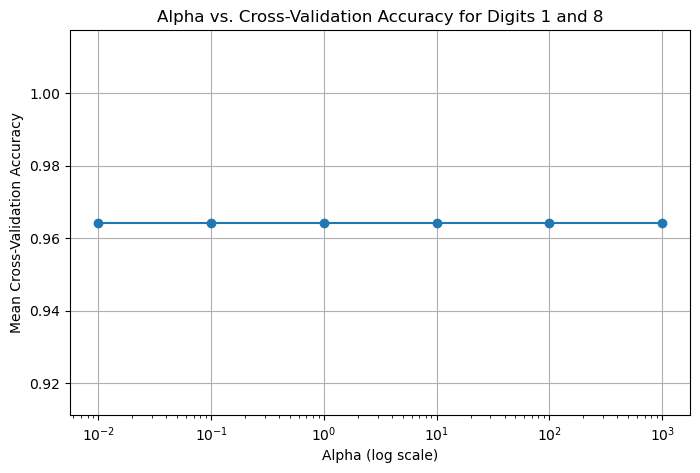

In [92]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd

# Select digits 1 and 8 from the original data
selected_digits = [1, 8]
X_subtrain, y_subtrain, X_subtest, y_subtest = select_digit_subset(
    Xtraindata, ytrainlabels, Xtestdata, ytestlabels, selected_digits
)

# Project the subset onto the first k principal components from Part 2
X_subtrain_pca = pca_k.transform(X_subtrain)
X_subtest_pca  = pca_k.transform(X_subtest)

# Use a Ridge classifier + cross-validation to compare multiple alpha values
alpha_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
ridge_clf = RidgeClassifier()

grid_search = GridSearchCV(ridge_clf, alpha_grid, cv=5, scoring='accuracy')
grid_search.fit(X_subtrain_pca, y_subtrain)

# Display cross-validation results for each alpha
cv_results = pd.DataFrame(grid_search.cv_results_)
alpha_scores = cv_results[['param_alpha', 'mean_test_score', 'std_test_score']]
print("Classification for digits 1 and 8:")

# Identify the alpha that gave the highest average CV accuracy
best_alpha = grid_search.best_params_['alpha']
best_cv_acc = grid_search.best_score_
print("Best cross-validation accuracy: {:.4f}".format(best_cv_acc))

# Retrain a final Ridge model with the best alpha, evaluate on test set
ridge_best = RidgeClassifier(alpha=best_alpha)
ridge_best.fit(X_subtrain_pca, y_subtrain)
test_accuracy = ridge_best.score(X_subtest_pca, y_subtest)
print(f"Test accuracy: {test_accuracy:.4f}")

# Extract alpha values and corresponding mean cross-validation scores
alpha_values = alpha_scores['param_alpha'].astype(float)
mean_cv_scores = alpha_scores['mean_test_score']

# Plot alpha vs. cross-validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(alpha_values, mean_cv_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Alpha vs. Cross-Validation Accuracy for Digits 1 and 8')
plt.grid(True)
plt.show()

# Part 5

Classification for digits 3 and 8:
Best cross-validation accuracy: 0.9588
Test accuracy: 0.9637
Classification for digits 2 and 7:
Best cross-validation accuracy: 0.9800
Test accuracy: 0.9748


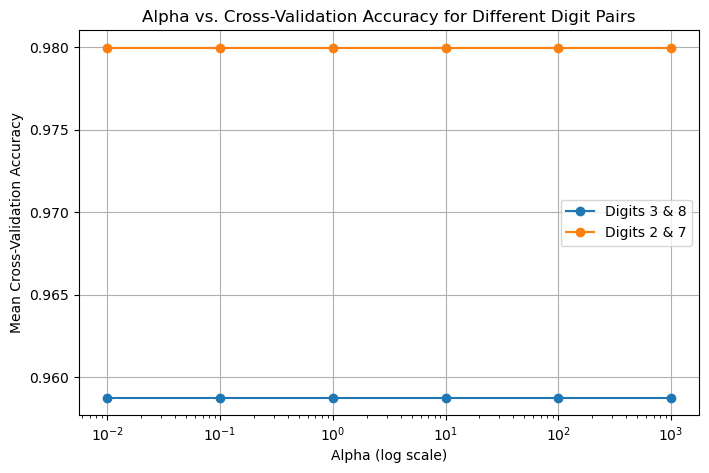

In [113]:
import matplotlib.pyplot as plt
import pandas as pd

# Digit pairs to repeat the classification procedure
digit_pairs = [(3, 8), (2, 7)]
results = {}

for pair in digit_pairs:
    print(f"Classification for digits {pair[0]} and {pair[1]}:")

    # Select these two digits from the data
    X_subtrain, y_subtrain, X_subtest, y_subtest = select_digit_subset(
        Xtraindata, ytrainlabels, Xtestdata, ytestlabels, list(pair)
    )

    # Project onto the first k PCs
    X_subtrain_pca = pca_k.transform(X_subtrain)
    X_subtest_pca = pca_k.transform(X_subtest)

    # Ridge Classifier + Cross-Validation
    alpha_grid = {'alpha': [0.01, 0.1, 1, 10, 100, 1000]}
    ridge_clf = RidgeClassifier()
    grid_search = GridSearchCV(ridge_clf, alpha_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_subtrain_pca, y_subtrain)

    # Save cross-validation results
    cv_results = pd.DataFrame(grid_search.cv_results_)
    alpha_scores = cv_results[['param_alpha', 'mean_test_score', 'std_test_score']]

    # Identify best alpha and accuracy
    best_alpha = grid_search.best_params_['alpha']
    best_cv_acc = grid_search.best_score_
    print(f"Best cross-validation accuracy: {best_cv_acc:.4f}")

    # Train final model
    ridge_best = RidgeClassifier(alpha=best_alpha)
    ridge_best.fit(X_subtrain_pca, y_subtrain)
    test_acc = ridge_best.score(X_subtest_pca, y_subtest)
    print(f"Test accuracy: {test_acc:.4f}")

    # Store results
    results[pair] = {
        "best_alpha": best_alpha,
        "best_cv_acc": best_cv_acc,
        "test_acc": test_acc,
        "alpha_scores": alpha_scores  # Store per pair
    }

# Plot results for both digit pairs in one plot
plt.figure(figsize=(8, 5))

for pair, res in results.items():
    alpha_values = res["alpha_scores"]['param_alpha'].astype(float)
    mean_cv_scores = res["alpha_scores"]['mean_test_score']
    plt.plot(alpha_values, mean_cv_scores, marker='o', linestyle='-', label=f'Digits {pair[0]} & {pair[1]}')

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Cross-Validation Accuracy')
plt.title('Alpha vs. Cross-Validation Accuracy for Different Digit Pairs')
plt.legend()
plt.grid(True)
plt.show()


# Part 6 & 7

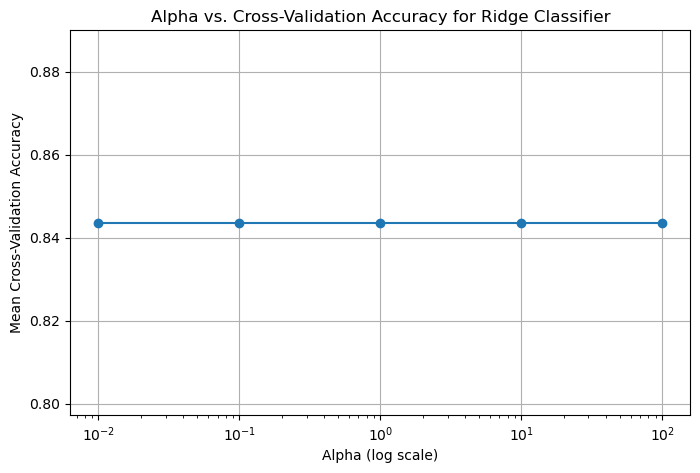

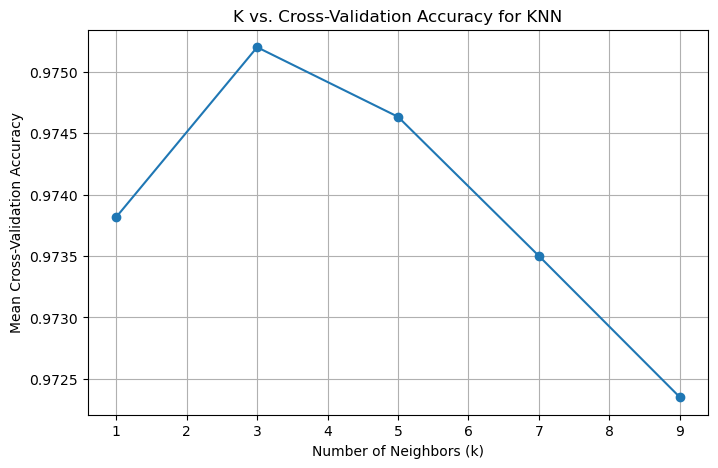

Training Models and Evaluating on Test Data:
Ridge Classifier - Test Accuracy: 0.8553, CV Accuracy: 0.8436
KNN Classifier - Test Accuracy: 0.9755, CV Accuracy: 0.9752
SVM Classifier - Test Accuracy: 0.9841
Confusion Matrices:


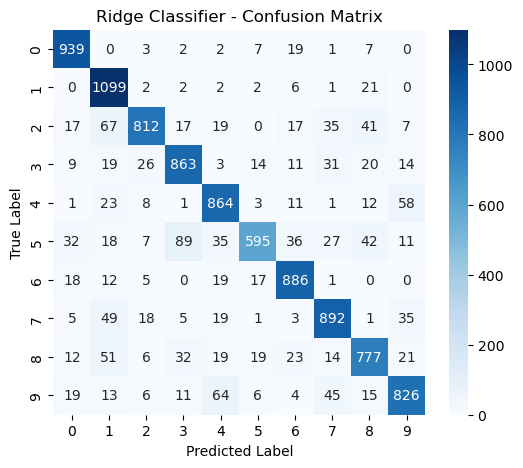

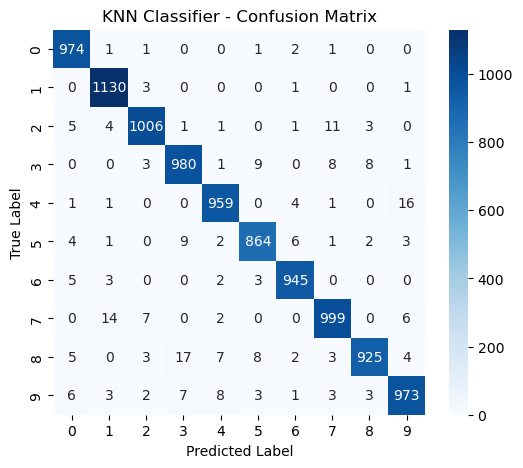

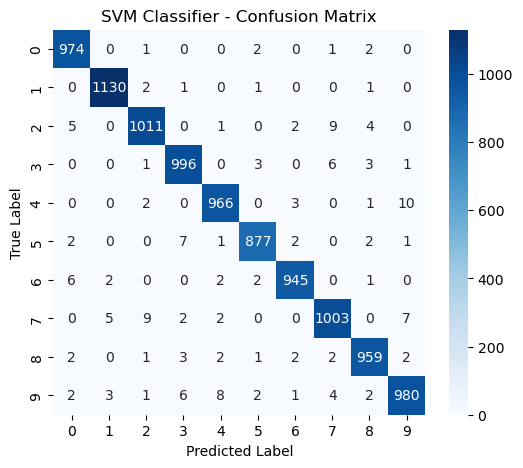

Classifier Performance Comparison:
SVM Classifier performs the best


In [119]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV

def select_and_evaluate_all_digits_with_svm(Xtraindata, ytrainlabels, Xtestdata, ytestlabels, k=59):
    # Apply PCA
    pca = PCA(n_components=k)
    Xtrain_pca = pca.fit_transform(Xtraindata)  
    Xtest_pca = pca.transform(Xtestdata)

    # Define hyperparameter grid for Ridge
    alpha_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}
    ridge_grid = GridSearchCV(RidgeClassifier(), alpha_grid, cv=5, scoring='accuracy', n_jobs=-1)
    ridge_grid.fit(Xtrain_pca, ytrainlabels)
    best_alpha_ridge = ridge_grid.best_params_['alpha']
    best_cv_acc_ridge = ridge_grid.best_score_
    
    # Extract results for Ridge
    cv_results_ridge = pd.DataFrame(ridge_grid.cv_results_)
    alpha_values = cv_results_ridge['param_alpha'].astype(float)
    mean_cv_scores_ridge = cv_results_ridge['mean_test_score']

    # Plot Alpha vs. Cross-Validation Accuracy for Ridge
    plt.figure(figsize=(8, 5))
    plt.plot(alpha_values, mean_cv_scores_ridge, marker='o', linestyle='-')
    plt.xscale('log')
    plt.xlabel('Alpha (log scale)')
    plt.ylabel('Mean Cross-Validation Accuracy')
    plt.title('Alpha vs. Cross-Validation Accuracy for Ridge Classifier')
    plt.grid(True)
    plt.show()
    
    # Define hyperparameter grid for KNN
    k_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
    knn_grid = GridSearchCV(KNeighborsClassifier(), k_grid, cv=5, scoring='accuracy', n_jobs=-1)
    knn_grid.fit(Xtrain_pca, ytrainlabels)
    best_k_knn = knn_grid.best_params_['n_neighbors']
    best_cv_acc_knn = knn_grid.best_score_
    
    # Extract results for KNN
    cv_results_knn = pd.DataFrame(knn_grid.cv_results_)
    k_values = cv_results_knn['param_n_neighbors']
    mean_cv_scores_knn = cv_results_knn['mean_test_score']

    # Plot K vs. Cross-Validation Accuracy for KNN
    plt.figure(figsize=(8, 5))
    plt.plot(k_values, mean_cv_scores_knn, marker='o', linestyle='-')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Mean Cross-Validation Accuracy')
    plt.title('K vs. Cross-Validation Accuracy for KNN')
    plt.grid(True)
    plt.show()
    
    # Initialize classifiers with best hyperparameters
    ridge_classifier = RidgeClassifier(alpha=best_alpha_ridge)
    knn_classifier = KNeighborsClassifier(n_neighbors=best_k_knn)
    svm_classifier = SVC()

    print("Training Models and Evaluating on Test Data:")

    # Train and evaluate Ridge classifier
    ridge_classifier.fit(Xtrain_pca, ytrainlabels)
    ytest_pred_ridge = ridge_classifier.predict(Xtest_pca)
    ridge_test_accuracy = accuracy_score(ytestlabels, ytest_pred_ridge)
    ridge_conf_matrix = confusion_matrix(ytestlabels, ytest_pred_ridge)
    print(f"Ridge Classifier - Test Accuracy: {ridge_test_accuracy:.4f}, CV Accuracy: {best_cv_acc_ridge:.4f}")

    # Train and evaluate KNN classifier
    knn_classifier.fit(Xtrain_pca, ytrainlabels)
    ytest_pred_knn = knn_classifier.predict(Xtest_pca)
    knn_test_accuracy = accuracy_score(ytestlabels, ytest_pred_knn)
    knn_conf_matrix = confusion_matrix(ytestlabels, ytest_pred_knn)
    print(f"KNN Classifier - Test Accuracy: {knn_test_accuracy:.4f}, CV Accuracy: {best_cv_acc_knn:.4f}")

    # Train and evaluate SVM classifier
    svm_classifier.fit(Xtrain_pca, ytrainlabels)
    ytest_pred_svm = svm_classifier.predict(Xtest_pca)
    svm_test_accuracy = accuracy_score(ytestlabels, ytest_pred_svm)
    svm_conf_matrix = confusion_matrix(ytestlabels, ytest_pred_svm)
    print(f"SVM Classifier - Test Accuracy: {svm_test_accuracy:.4f}")

    # Function to plot confusion matrix
    def plot_confusion_matrix(conf_matrix, title):
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(ytestlabels), yticklabels=np.unique(ytestlabels))
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title(title)
        plt.show()

    # Plot confusion matrices
    print("Confusion Matrices:")
    plot_confusion_matrix(ridge_conf_matrix, "Ridge Classifier - Confusion Matrix")
    plot_confusion_matrix(knn_conf_matrix, "KNN Classifier - Confusion Matrix")
    plot_confusion_matrix(svm_conf_matrix, "SVM Classifier - Confusion Matrix")

    return ridge_test_accuracy, knn_test_accuracy, svm_test_accuracy

# Run the function using your dataset
ridge_test_accuracy, knn_test_accuracy, svm_test_accuracy = select_and_evaluate_all_digits_with_svm(
    Xtraindata, ytrainlabels, Xtestdata, ytestlabels
)

# Determine the best classifier based on test accuracy
print("Classifier Performance Comparison:")
if ridge_test_accuracy > knn_test_accuracy and ridge_test_accuracy > svm_test_accuracy:
    print("Ridge Classifier performs the best")
elif knn_test_accuracy > ridge_test_accuracy and knn_test_accuracy > svm_test_accuracy:
    print("KNN Classifier performs the best")
else:
    print("SVM Classifier performs the best")